In [266]:
import numpy as np
import scipy.signal as ss
from scipy.signal import convolve

import scipy.integrate as si


import matplotlib.pyplot as plt


import matplotlib.patches as plt2



from functions import *



clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

#### ADC specs

In [267]:
fb = 10e6  # ADC bandwidth
OSR = 16  # Oversampling ratio
order = 2  # Order of the modulator
h_inf = 2  # out-of-band gain
n_sample = 2**12  # Number of samples

#### Discrete time NTF synthesis

[0.000244140625, 0.5, -150, 40]


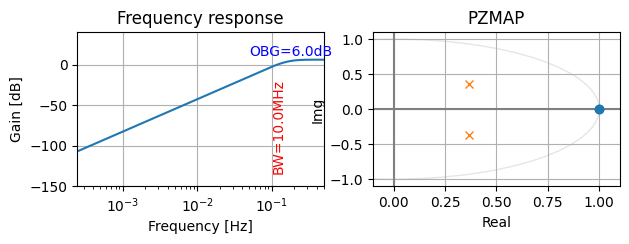

      +1.000e+00 z^2 -2.000e+00 z^1 +1.000e+00
ntf = ----------------------------------------
      +1.000e+00 z^2 -7.321e-01 z^1 +2.679e-01


In [268]:
# create ntf
ntf = create_ntf(order, h_inf, 1, 0)

ntf[0] = ntf[0] * h_inf

z, p, k = ss.tf2zpk(ntf[0], ntf[1])
f, h = calc_freq(ntf, n_sample, 1, continuous=False)
fig, axs = plt.subplots(1, 2, figsize=(7, 2))
ax_lim = [f[1], f[int(n_sample / 2)], -150, 40]
print(ax_lim)
plot_freq(f, db20(h), axs[0], ax_lim)
axs[0].vlines(fb, ax_lim[2], ax_lim[3], color="red", linestyle=":")
axs[0].text(
    0.1,
    ax_lim[2] + 0.1 * (ax_lim[3] - ax_lim[2]),
    "BW={:.1f}MHz".format(fb / 1e6),
    rotation=90,
    color="red",
)
axs[0].text(1 / 20, db20(h_inf) + 5, f"OBG={db20(h_inf):.1f}dB", color="blue")

plot_pzmap(z, p, axs[1], continuous=False)
plt.show()

# print transfer function
# print("b = " + ", ".join(["{:.6f}".format(x) for x in ntf[0]]))
# print("a = " + ", ".join(["{:.6f}".format(x) for x in ntf[1]]))
# print("z = " + ", ".join(["{:.6f}".format(x) for x in z]))
# print("p = " + ", ".join(["{:.6f}".format(x) for x in p]))
# print("k = " + "{:.6f}".format(k))
tf_print(ntf, "ntf", "z")

#### Integrator modelling

In [269]:
fs = 1
length_imp = 1000
tdelay = 0.5  # Excess loop delay time

# Integrator parameter design
OTA_gain = np.array([1000, 1000])
gbw_over_fs = np.array([3, 1.5])
second_pole = np.array([3, 3])
wp1 = 2 * np.pi * gbw_over_fs / OTA_gain
wp2 = 2 * np.pi * gbw_over_fs * second_pole

# zero array define
A_num = np.zeros((len(OTA_gain), 4))
A_den = np.zeros((len(OTA_gain), 4))
tmp = np.zeros((len(OTA_gain), 5))
int_num = np.zeros((len(OTA_gain), 4))
int_den = np.zeros((len(OTA_gain), 4))

for i in range(len(OTA_gain)):

    A_num[i, :] = np.array([0, 0, 0, OTA_gain[i]])
    A_den[i, :] = np.convolve([0, 1 / wp1[i], 1], [1 / wp2[i], 1])
    tmp[i, :] = np.convolve(A_num[i, :] + A_den[i, :], [1, 0])
    int_num[i, :] = fs * A_num[i, :]
    int_den[i, :] = tmp[i, 1:] + fs * A_den[i, :]

# print(A_num[0, :])
# print(A_den[0])
# print(tmp[0])
# print(tmp[0, 1:])
# print(int_num[0])
# print(int_den)

#### Impulse response

In [270]:
# Transfer functions
ctmod2_ntf = ss.dlti(ntf[0], ntf[1])
int1 = (int_num[0], int_den[0])
int2 = (int_num[1], int_den[1])

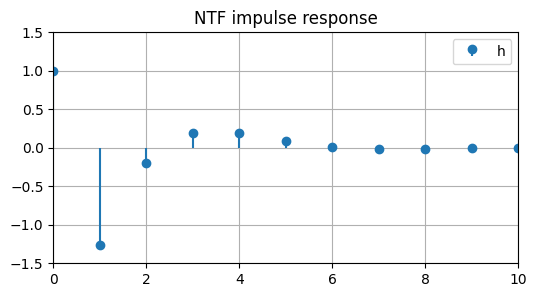

In [279]:
# closed loop fitting array construction
# Impulse
u1 = np.zeros(length_imp)
u1[0] = 1
# print(u1)
_, h = ss.dimpulse(ctmod2_ntf, n=length_imp)
h = h[0][:, 0]
# print(h)
v0c = np.insert(h, 0, 0)
v0c = v0c[0:length_imp]
# print(v0c)

# plot
xlim = 10
plt.figure(figsize=(6, 3))
plt.stem(
    np.linspace(0, xlim, xlim + 1),
    h[0 : xlim + 1],
    basefmt=" ",
    linefmt=clrs[0],
)
plt.legend(["h"], loc="best")
plt.title("NTF impulse response")
plt.axis([0, xlim, -1.5, 1.5])
plt.grid()
plt.show()

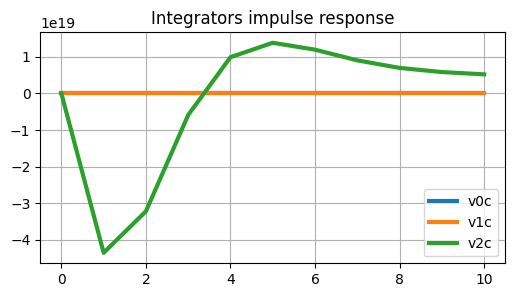

In [289]:
_, int1_h = ss.impulse(int1, length_imp)
_, int2_h = ss.impulse(int2, length_imp)

v1c = convolve(v0c, int1_h, mode="full") * (int1_h[1] - int1_h[0])
v2c = convolve(v1c, int2_h, mode="full") * (int2_h[1] - int2_h[0])

# plot
plt.figure(figsize=(6, 3))
plt.plot(
    np.linspace(0, xlim, xlim + 1),
    v0c[0 : xlim + 1],
    linewidth=3.0,
    color=clrs[0],
)
plt.plot(
    np.linspace(0, xlim, xlim + 1),
    v1c[0 : xlim + 1],
    linewidth=3.0,
    color=clrs[1],
)
plt.plot(
    np.linspace(0, xlim, xlim + 1),
    v2c[0 : xlim + 1],
    linewidth=3.0,
    color=clrs[2],
)
plt.legend(["v0c", "v1c", "v2c"], loc="best")
plt.title("Integrators impulse response")
# plt.axis([0, xlim, -5, 5])
plt.grid()
plt.show()

In [291]:
print(len(v1c))
print(v2c[0:10])

1099
[ 0.00000000e+00 -4.35509906e+19 -3.22224842e+19 -5.92622420e+18
  9.87757061e+18  1.38152086e+19  1.19315880e+19  9.01532749e+18
  6.94796100e+18  5.81985900e+18]
